# **Version 1**
*   The Model Accuracy was good
*   But the model had overfitted
*   The model was classifying news from BBC NEWs as Fake






In [ ]:
# Step 1: Install required libraries
!pip install textblob shap joblib scikit-learn --quiet

# Step 2: Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re
import warnings
warnings.filterwarnings("ignore")

# Step 3: Load data
df_fake = pd.read_csv("Fake.csv")
df_real = pd.read_csv("True.csv")

# Add labels
df_fake["label"] = 0  # Fake news
df_real["label"] = 1  # Real news

# Combine and shuffle
df = pd.concat([df_fake, df_real], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

# Step 4: Text preprocessing function (CRITICAL - must match Flask preprocessing)
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Apply preprocessing
df["text"] = df["text"].apply(preprocess_text)
df["title"] = df["title"].apply(preprocess_text)

# Step 5: Feature Engineering
df["text_length"] = df["text"].apply(len)
df["title_length"] = df["title"].apply(len)

# Sentiment analysis
def get_polarity(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return 0.0

df["polarity"] = df["text"].apply(get_polarity)
df["subjectivity"] = df["text"].apply(lambda x: TextBlob(x).sentiment.subjectivity if x else 0.0)

# Sentiment category
def get_sentiment(p):
    if p > 0.3:
        return "happy"
    elif p < -0.3:
        return "angry"
    elif -0.3 <= p <= -0.1:
        return "sad"
    else:
        return "neutral"

df["sentiment"] = df["polarity"].apply(get_sentiment)

# Step 6: Sentiment Visualization
plt.figure(figsize=(8, 5))
sentiment_counts = df["sentiment"].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title("Sentiment Distribution of News Articles")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Dataset Info:")
print(f"Total articles: {len(df)}")
print(f"Fake news: {len(df[df['label']==0])}")
print(f"Real news: {len(df[df['label']==1])}")
print(f"Sentiment distribution:\n{sentiment_counts}")

# Step 7: Prepare data for training
X_text = df["text"]
y = df["label"]

# Train-test split with stratification
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nTraining set size: {len(X_train_text)}")
print(f"Test set size: {len(X_test_text)}")

# Step 8: Vectorization
# IMPORTANT: Use consistent parameters
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

# Fit vectorizer on training data only
X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

print(f"Feature matrix shape: {X_train.shape}")
print(f"Number of features: {len(tfidf.get_feature_names_out())}")

# Step 9: Train model
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

# Step 10: Evaluation
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Accuracy: {acc*100:.2f}%")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Step 11: Test the saved models before saving
print("\nTesting model and vectorizer consistency...")
test_text = "This is a test news article about politics and economy."
test_processed = preprocess_text(test_text)
test_vector = tfidf.transform([test_processed])
test_pred = model.predict(test_vector)
test_prob = model.predict_proba(test_vector)
print(f"Test prediction: {'Real' if test_pred[0]==1 else 'Fake'}")
print(f"Test confidence: {test_prob.max():.3f}")

# Step 12: Save model, vectorizer, and preprocessing info
# Save the fitted vectorizer and model
joblib.dump(model, "news_fake_real_model.joblib")
joblib.dump(tfidf, "news_vectorizer.joblib")

# Save dataset statistics for Flask app
stats_data = {
    'accuracy': float(acc),
    'confusion_matrix': cm.tolist(),
    'sentiment_distribution': sentiment_counts.to_dict(),
    'total_samples': len(df),
    'feature_count': len(tfidf.get_feature_names_out())
}

joblib.dump(stats_data, "model_stats.joblib")

print("\nModel and vectorizer saved successfully!")
print("Files created:")
print("- news_fake_real_model.joblib")
print("- news_vectorizer.joblib")
print("- model_stats.joblib")

# Step 13: Download files from Colab
from google.colab import files
files.download("news_fake_real_model.joblib")
files.download("news_vectorizer.joblib")
files.download("model_stats.joblib")

print("\nTraining completed successfully!")

# **Version 2**

*   Improved the Algorithm Significantlly
*   We also added Sentiment Analysis for the News texts

*   We found that the problem was not with the Algorithm
*   The problem was that the True.csv had a pattern and the model learned those patterns hence classifying real life news as fake



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 3.4 MB/s eta 0:00:00
Dataset loaded: 44898 articles
Fake: 23481, Real: 21417
Extracting features...


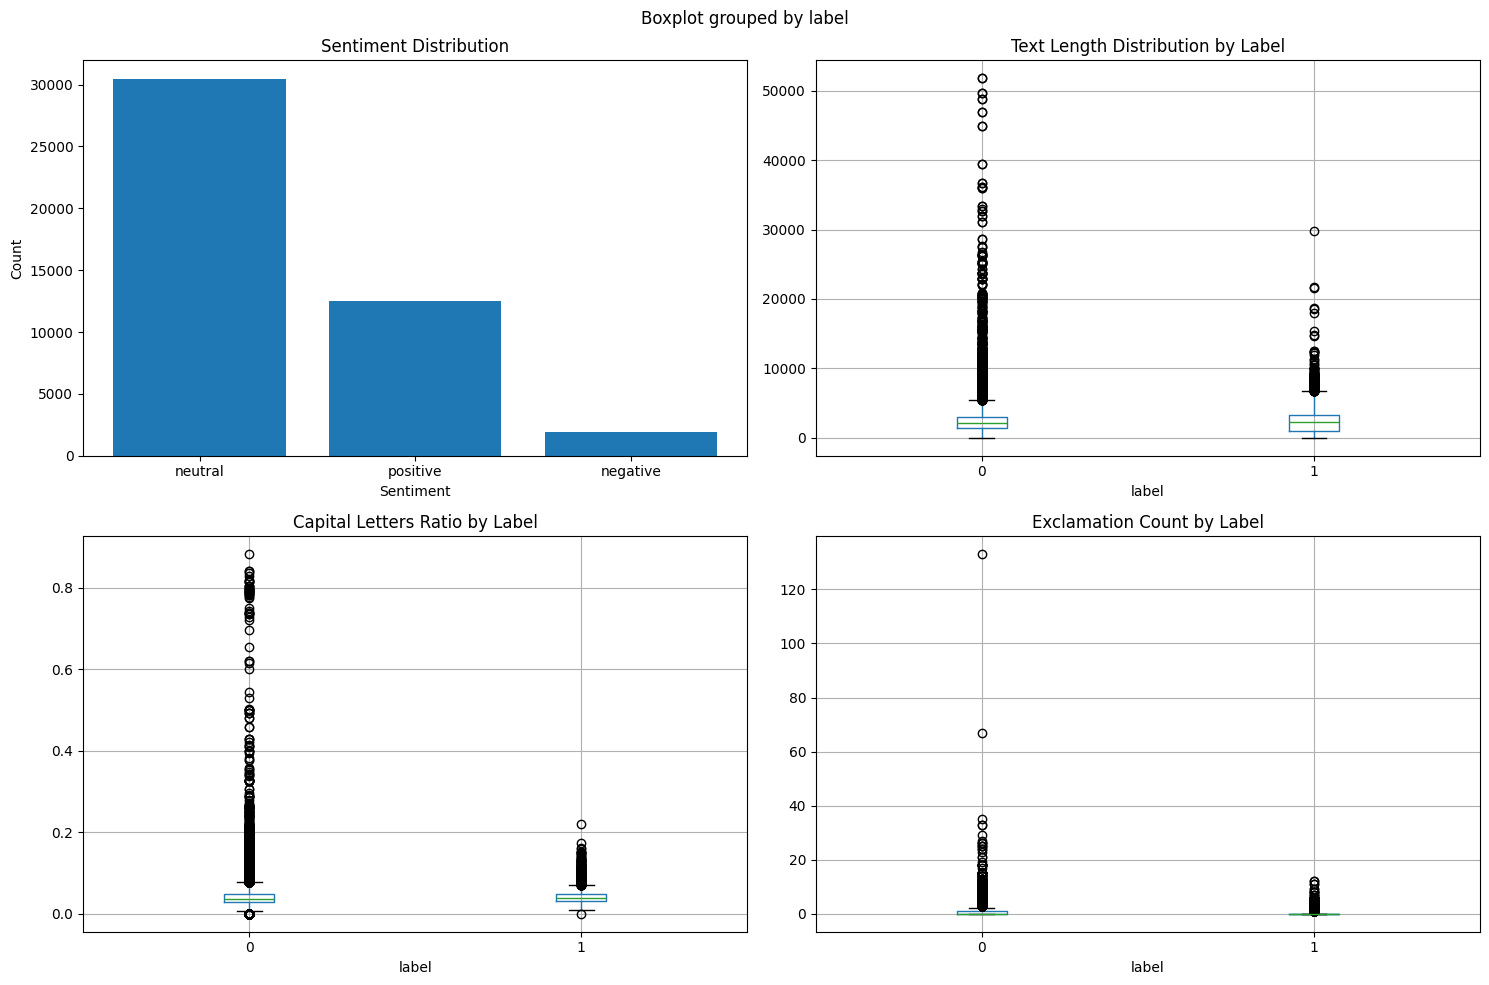

Training set size: 35918
Test set size: 8980
Combined feature matrix shape: (35918, 11018)
Training logistic...
logistic - Accuracy: 0.9944, AUC: 0.9996
Training random_forest...
random_forest - Accuracy: 0.9973, AUC: 0.9999
Training xgboost...
xgboost - Accuracy: 0.9987, AUC: 1.0000

Ensemble Model Performance:
Accuracy: 99.88%
AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



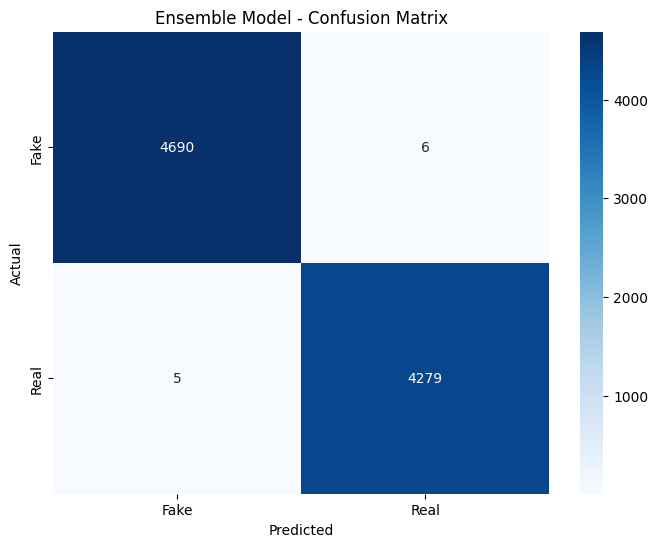

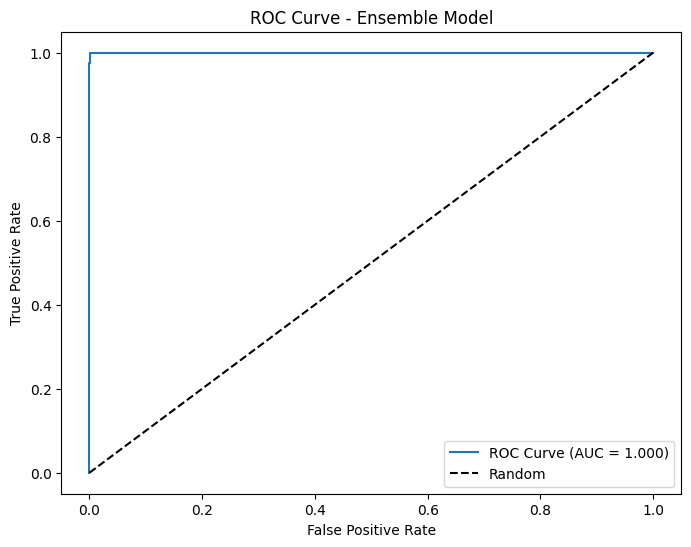


Cross-validation scores: [0.99791203 0.99749443 0.99693764 0.99902548 0.99805095]
Mean CV accuracy: 0.9979 (+/- 0.0014)

Testing with diverse examples:
Example 1: Fake (Confidence: 0.865)
Text: Scientists at MIT have developed a revolutionary new battery...

Example 2: Fake (Confidence: 0.940)
Text: BREAKING: SHOCKING truth about celebrities revealed! You won...

Example 3: Fake (Confidence: 0.815)
Text: The Federal Reserve announced new interest rate changes foll...

Example 4: Fake (Confidence: 0.978)
Text: URGENT: This miracle cure will solve all your problems insta...

Example 5: Fake (Confidence: 0.929)
Text: Climate change continues to impact global weather patterns a...

Example 6: Fake (Confidence: 0.911)
Text: EXPOSED: Government conspiracy revealed by anonymous insider...


ENHANCED MODEL TRAINING COMPLETED!
Final Ensemble Accuracy: 99.88%
Final Ensemble AUC: 1.0000
Cross-validation Mean: 0.9979

Files saved:
- enhanced_news_model.joblib
- enhanced_model_stats.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Files downloaded successfully!


In [ ]:
# Step 1: Install required libraries
!pip install textblob shap joblib scikit-learn nltk wordcloud xgboost --quiet

# Step 2: Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from textblob import TextBlob
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import re
import nltk
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Step 3: Load data
df_fake = pd.read_csv("Fake.csv",on_bad_lines='skip')
df_real = pd.read_csv("True.csv",on_bad_lines='skip')

# Add labels
df_fake["label"] = 0  # Fake news
df_real["label"] = 1  # Real news

# Combine and shuffle
df = pd.concat([df_fake, df_real], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset loaded: {len(df)} articles")
print(f"Fake: {len(df_fake)}, Real: {len(df_real)}")

# Step 4: Enhanced Text preprocessing
def advanced_preprocess_text(text):
    """
    More balanced preprocessing that retains important information
    """
    if pd.isna(text) or not text:
        return ""

    text = str(text).lower()

    # Keep some punctuation that might be important for fake news detection
    # Remove excessive punctuation but keep structure
    text = re.sub(r'[!]{2,}', ' EXCLAMATION_MULTIPLE ', text)  # Multiple exclamations
    text = re.sub(r'[?]{2,}', ' QUESTION_MULTIPLE ', text)    # Multiple questions
    text = re.sub(r'[.]{3,}', ' DOTS_MULTIPLE ', text)       # Multiple dots

    # Handle all caps words (common in fake news)
    words = text.split()
    caps_count = sum(1 for word in words if word.isupper() and len(word) > 2)
    if caps_count > 0:
        text += f' CAPS_WORDS_{min(caps_count, 5)}'

    # Remove URLs, email addresses
    text = re.sub(r'http\S+|www\S+|https\S+', ' URL ', text)
    text = re.sub(r'\S+@\S+', ' EMAIL ', text)

    # Remove excessive whitespace and special characters
    text = re.sub(r'[^a-zA-Z\s_]', ' ', text)
    text = ' '.join(text.split())

    return text

# Step 5: Enhanced Feature Engineering
def extract_advanced_features(df):
    """Extract multiple types of features"""

    # Apply preprocessing
    df["processed_text"] = df["text"].apply(advanced_preprocess_text)
    df["processed_title"] = df["title"].apply(advanced_preprocess_text)

    # Basic length features
    df["text_length"] = df["text"].apply(len)
    df["title_length"] = df["title"].apply(len)
    df["word_count"] = df["processed_text"].apply(lambda x: len(x.split()))
    df["sentence_count"] = df["text"].apply(lambda x: len(x.split('.')))

    # Readability features
    df["avg_word_length"] = df["processed_text"].apply(
        lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0
    )
    df["avg_sentence_length"] = df["word_count"] / df["sentence_count"].replace(0, 1)

    # Punctuation features
    df["exclamation_count"] = df["text"].apply(lambda x: x.count('!'))
    df["question_count"] = df["text"].apply(lambda x: x.count('?'))
    df["caps_ratio"] = df["text"].apply(
        lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
    )

    # URL and mention features
    df["url_count"] = df["text"].apply(lambda x: len(re.findall(r'http\S+|www\S+', x)))
    df["mention_count"] = df["text"].apply(lambda x: len(re.findall(r'@\w+', x)))

    # Enhanced sentiment analysis using both TextBlob and VADER
    analyzer = SentimentIntensityAnalyzer()

    def get_sentiment_features(text):
        # TextBlob sentiment
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity

        # VADER sentiment
        vader_scores = analyzer.polarity_scores(text)

        return {
            'polarity': polarity,
            'subjectivity': subjectivity,
            'compound': vader_scores['compound'],
            'positive': vader_scores['pos'],
            'negative': vader_scores['neg'],
            'neutral': vader_scores['neu']
        }

    sentiment_features = df["text"].apply(get_sentiment_features)
    sentiment_df = pd.DataFrame(sentiment_features.tolist())
    df = pd.concat([df, sentiment_df], axis=1)

    # Categorical sentiment
    def get_sentiment_category(polarity):
        if polarity > 0.1:
            return "positive"
        elif polarity < -0.1:
            return "negative"
        else:
            return "neutral"

    df["sentiment_category"] = df["polarity"].apply(get_sentiment_category)

    # Title-text consistency features
    df["title_text_similarity"] = df.apply(
        lambda row: len(set(row["processed_title"].split()) &
                       set(row["processed_text"].split()[:50])) /
                   max(len(set(row["processed_title"].split())), 1), axis=1
    )

    return df

# Apply feature engineering
print("Extracting features...")
df = extract_advanced_features(df)

# Step 6: Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sentiment distribution
sentiment_counts = df["sentiment_category"].value_counts()
axes[0,0].bar(sentiment_counts.index, sentiment_counts.values)
axes[0,0].set_title("Sentiment Distribution")
axes[0,0].set_xlabel("Sentiment")
axes[0,0].set_ylabel("Count")

# Text length by label
df.boxplot(column='text_length', by='label', ax=axes[0,1])
axes[0,1].set_title("Text Length Distribution by Label")

# Caps ratio by label
df.boxplot(column='caps_ratio', by='label', ax=axes[1,0])
axes[1,0].set_title("Capital Letters Ratio by Label")

# Exclamation count by label
df.boxplot(column='exclamation_count', by='label', ax=axes[1,1])
axes[1,1].set_title("Exclamation Count by Label")

plt.tight_layout()
plt.show()

# Step 7: Prepare training data
# Select features for training
feature_columns = [
    'text_length', 'title_length', 'word_count', 'sentence_count',
    'avg_word_length', 'avg_sentence_length', 'exclamation_count',
    'question_count', 'caps_ratio', 'url_count', 'mention_count',
    'polarity', 'subjectivity', 'compound', 'positive', 'negative',
    'neutral', 'title_text_similarity'
]

X_numerical = df[feature_columns]
X_text = df["processed_text"]
y = df["label"]

# Train-test split
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_numerical, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set size: {len(X_train_text)}")
print(f"Test set size: {len(X_test_text)}")

# Step 8: Enhanced Vectorization with multiple approaches
# TF-IDF with more balanced parameters
tfidf = TfidfVectorizer(
    max_features=8000,  # Increased from 5000
    stop_words='english',
    ngram_range=(1, 3),  # Include trigrams
    min_df=3,           # Slightly more restrictive
    max_df=0.85,        # More restrictive to remove very common words
    sublinear_tf=True,  # Use sublinear tf scaling
    norm='l2'
)

# Count vectorizer for character n-grams (helps with stylistic analysis)
char_vectorizer = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    max_features=3000,
    stop_words='english'
)

# Fit vectorizers
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

X_train_char = char_vectorizer.fit_transform(X_train_text)
X_test_char = char_vectorizer.transform(X_test_text)

# Scale numerical features
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Combine all features
from scipy.sparse import hstack, csr_matrix

X_train_combined = hstack([
    X_train_tfidf,
    X_train_char,
    csr_matrix(X_train_num_scaled)
])

X_test_combined = hstack([
    X_test_tfidf,
    X_test_char,
    csr_matrix(X_test_num_scaled)
])

print(f"Combined feature matrix shape: {X_train_combined.shape}")

# Step 9: Train multiple models and create ensemble
models = {
    'logistic': LogisticRegression(
        solver='liblinear',
        random_state=42,
        C=1.0,
        class_weight='balanced'  # Handle class imbalance
    ),
    'random_forest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=15,
        min_samples_split=5,
        class_weight='balanced'
    ),
    'xgboost': XGBClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=1
    )
}

# Train individual models
trained_models = {}
model_scores = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_combined, y_train)
    trained_models[name] = model

    # Evaluate
    y_pred = model.predict(X_test_combined)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test_combined)[:, 1])
    model_scores[name] = {'accuracy': acc, 'auc': auc}

    print(f"{name} - Accuracy: {acc:.4f}, AUC: {auc:.4f}")

# Create ensemble model
ensemble = VotingClassifier([
    ('logistic', trained_models['logistic']),
    ('rf', trained_models['random_forest']),
    ('xgb', trained_models['xgboost'])
], voting='soft')

ensemble.fit(X_train_combined, y_train)

# Step 10: Evaluate ensemble
y_pred_ensemble = ensemble.predict(X_test_combined)
y_proba_ensemble = ensemble.predict_proba(X_test_combined)

acc_ensemble = accuracy_score(y_test, y_pred_ensemble)
auc_ensemble = roc_auc_score(y_test, y_proba_ensemble[:, 1])

print(f"\nEnsemble Model Performance:")
print(f"Accuracy: {acc_ensemble*100:.2f}%")
print(f"AUC: {auc_ensemble:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_ensemble)}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Ensemble Model - Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_ensemble[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_ensemble:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble Model')
plt.legend()
plt.show()

# Step 11: Cross-validation
cv_scores = cross_val_score(ensemble, X_train_combined, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Step 12: Test with diverse examples
test_examples = [
    "Scientists at MIT have developed a revolutionary new battery technology that could change electric vehicles forever.",
    "BREAKING: SHOCKING truth about celebrities revealed! You won't believe what happens next!!!",
    "The Federal Reserve announced new interest rate changes following economic indicators.",
    "URGENT: This miracle cure will solve all your problems instantly! Doctors hate this trick!",
    "Climate change continues to impact global weather patterns according to recent research.",
    "EXPOSED: Government conspiracy revealed by anonymous insider with shocking evidence!"
]

print("\nTesting with diverse examples:")
for i, text in enumerate(test_examples):
    # Preprocess
    processed = advanced_preprocess_text(text)

    # Extract numerical features (simplified for testing)
    text_features = [
        len(text), len(text.split()), len(text.split('!')),
        len(text.split('?')), sum(1 for c in text if c.isupper()) / len(text),
        TextBlob(text).sentiment.polarity, TextBlob(text).sentiment.subjectivity,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0  # Padding for missing features
    ]

    # Vectorize
    tfidf_vec = tfidf.transform([processed])
    char_vec = char_vectorizer.transform([processed])
    num_vec = scaler.transform([text_features])

    # Combine features
    combined_vec = hstack([tfidf_vec, char_vec, csr_matrix(num_vec)])

    # Predict
    pred = ensemble.predict(combined_vec)[0]
    proba = ensemble.predict_proba(combined_vec)[0]

    print(f"Example {i+1}: {'Real' if pred == 1 else 'Fake'} "
          f"(Confidence: {max(proba):.3f})")
    print(f"Text: {text[:60]}...")
    print()

# Step 13: Save enhanced model components
# Save all components needed for prediction
model_components = {
    'ensemble': ensemble,
    'tfidf_vectorizer': tfidf,
    'char_vectorizer': char_vectorizer,
    'scaler': scaler,
    'feature_columns': feature_columns
}

joblib.dump(model_components, "enhanced_news_model.joblib")

# Save enhanced statistics
enhanced_stats = {
    'ensemble_accuracy': float(acc_ensemble),
    'ensemble_auc': float(auc_ensemble),
    'individual_scores': model_scores,
    'cv_scores': cv_scores.tolist(),
    'confusion_matrix': cm.tolist(),
    'feature_count': X_train_combined.shape[1],
    'training_samples': len(X_train_text)
}

joblib.dump(enhanced_stats, "enhanced_model_stats.joblib")

print("\n" + "="*50)
print("ENHANCED MODEL TRAINING COMPLETED!")
print("="*50)
print(f"Final Ensemble Accuracy: {acc_ensemble*100:.2f}%")
print(f"Final Ensemble AUC: {auc_ensemble:.4f}")
print(f"Cross-validation Mean: {cv_scores.mean():.4f}")
print("\nFiles saved:")
print("- enhanced_news_model.joblib")
print("- enhanced_model_stats.joblib")

# Download files (for Colab)
try:
    from google.colab import files
    files.download("enhanced_news_model.joblib")
    files.download("enhanced_model_stats.joblib")
    print("Files downloaded successfully!")
except:
    print("Not running in Colab - files saved locally.")

# Version **3**

*   We added another dataset of BBC News
*   So the model doesnot only cosider news from True.csv as Real



Dataset loaded: 87013 articles
Fake: 23481
True: 21417
BBC: 42115
Total Real: 63532
Extracting features...


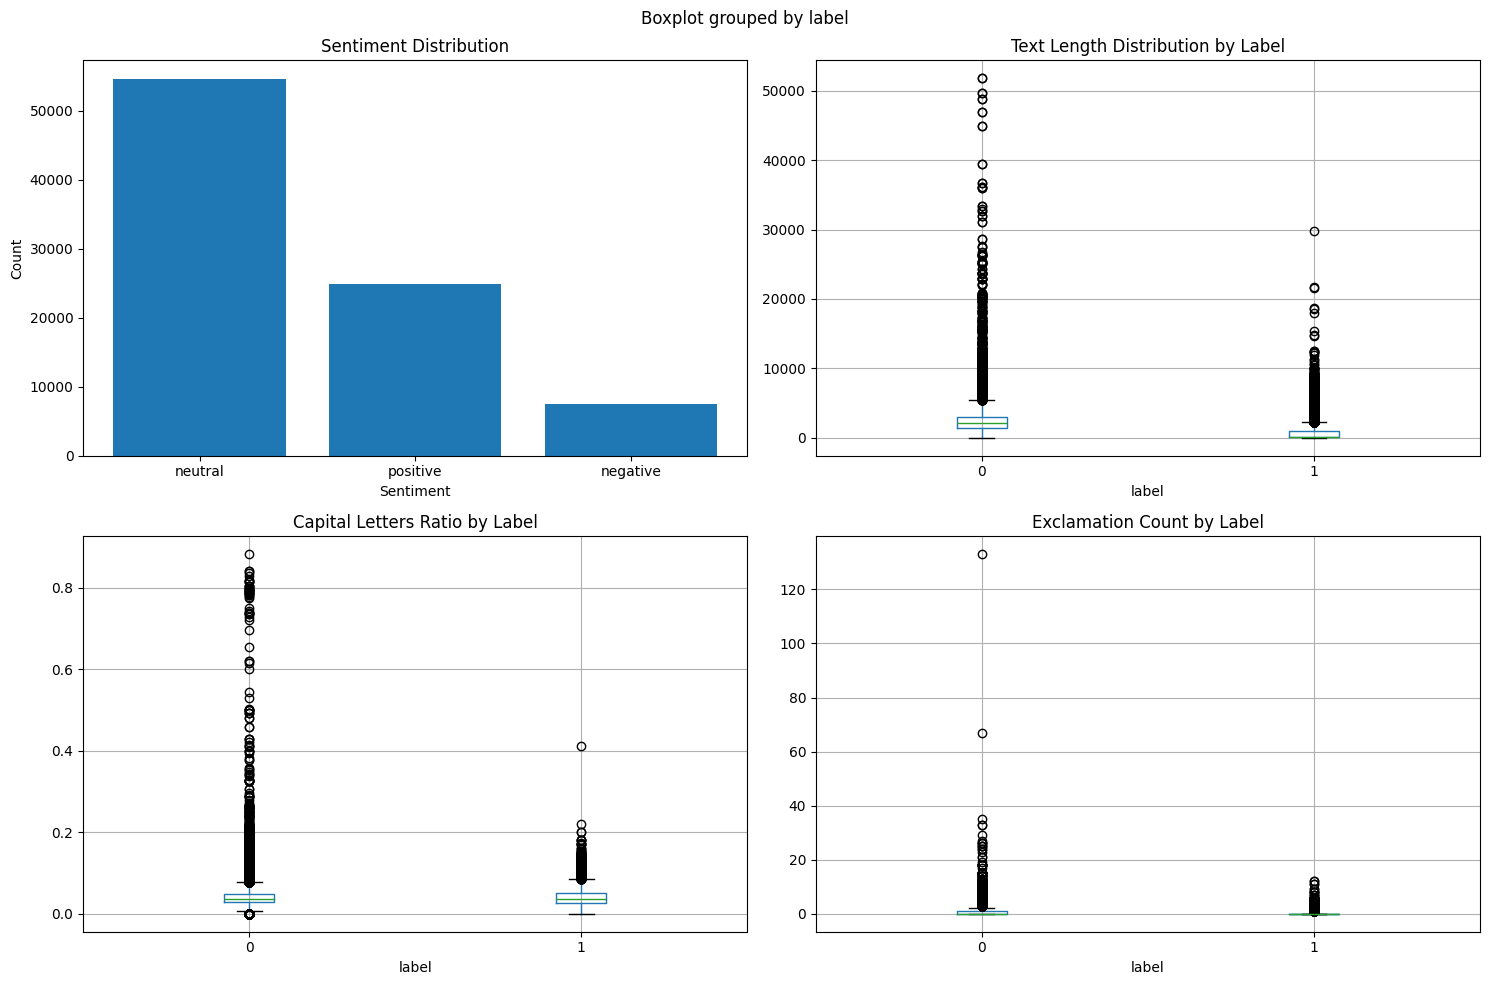

Training set size: 69610
Test set size: 17403
Combined feature matrix shape: (69610, 11018)
Training logistic...
logistic - Accuracy: 0.9941, AUC: 0.9994
Training random_forest...
random_forest - Accuracy: 0.9925, AUC: 0.9998
Training xgboost...
xgboost - Accuracy: 0.9975, AUC: 0.9998

Ensemble Model Performance:
Accuracy: 99.76%
AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4696
           1       1.00      1.00      1.00     12707

    accuracy                           1.00     17403
   macro avg       1.00      1.00      1.00     17403
weighted avg       1.00      1.00      1.00     17403



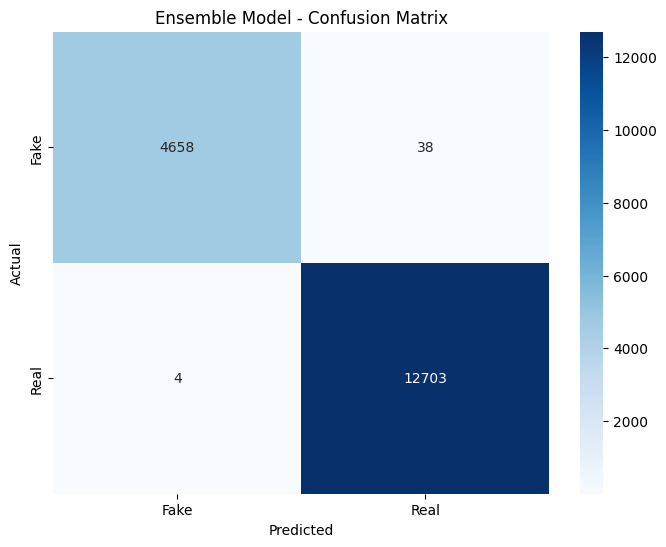

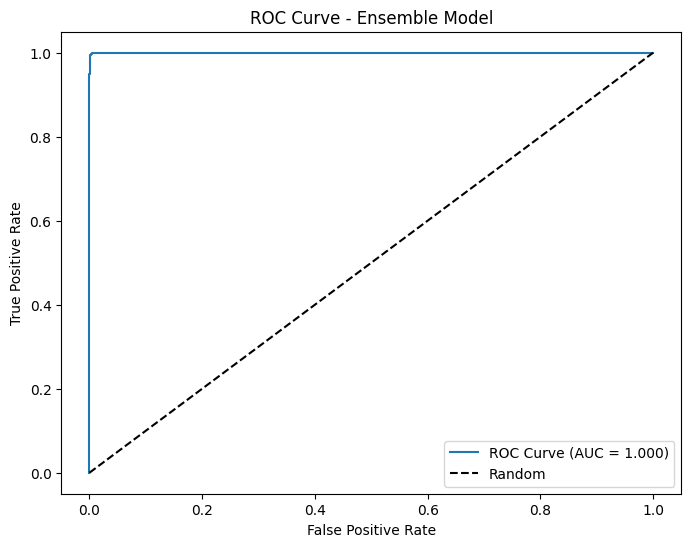


Cross-validation scores: [0.99719868 0.99655222 0.99669588 0.99762965 0.99712685]
Mean CV accuracy: 0.9970 (+/- 0.0008)

Testing with diverse examples:
Example 1: Fake (Confidence: 0.555)
Text: Scientists at MIT have developed a revolutionary new battery...

Example 2: Fake (Confidence: 0.557)
Text: BREAKING: SHOCKING truth about celebrities revealed! You won...

Example 3: Real (Confidence: 0.509)
Text: The Federal Reserve announced new interest rate changes foll...

Example 4: Fake (Confidence: 0.767)
Text: URGENT: This miracle cure will solve all your problems insta...

Example 5: Fake (Confidence: 0.558)
Text: Climate change continues to impact global weather patterns a...

Example 6: Fake (Confidence: 0.638)
Text: EXPOSED: Government conspiracy revealed by anonymous insider...


ENHANCED MODEL TRAINING COMPLETED!
Final Ensemble Accuracy: 99.76%
Final Ensemble AUC: 1.0000
Cross-validation Mean: 0.9970

Dataset Summary:
- Fake articles: 23481
- True.csv articles: 21417
- BBC articl

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Files downloaded successfully!


In [ ]:
# Step 1: Install required libraries
!pip install textblob shap joblib scikit-learn nltk wordcloud xgboost --quiet

# Step 2: Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from textblob import TextBlob
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import re
import nltk
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Step 3: Load data
df_fake = pd.read_csv("Fake.csv", on_bad_lines='skip')
df_true = pd.read_csv("True.csv", on_bad_lines='skip')
df_bbc = pd.read_csv("bbc_news.csv", on_bad_lines='skip')

# Standardize column names for BBC dataset
df_bbc_standardized = df_bbc.copy()
df_bbc_standardized['text'] = df_bbc_standardized['description']  # Use description as text
df_bbc_standardized['subject'] = 'BBC News'  # Add a subject category
df_bbc_standardized['date'] = df_bbc_standardized['pubDate']  # Use pubDate as date

# Keep only the required columns for consistency
df_bbc_final = df_bbc_standardized[['title', 'text', 'subject', 'date']]

# Add labels
df_fake["label"] = 0  # Fake news
df_true["label"] = 1  # Real news
df_bbc_final["label"] = 1  # Real news (BBC)

# Combine all datasets and shuffle
df = pd.concat([df_fake, df_true, df_bbc_final], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset loaded: {len(df)} articles")
print(f"Fake: {len(df_fake)}")
print(f"True: {len(df_true)}")
print(f"BBC: {len(df_bbc_final)}")
print(f"Total Real: {len(df_true) + len(df_bbc_final)}")

# Step 4: Enhanced Text preprocessing
def advanced_preprocess_text(text):
    """
    More balanced preprocessing that retains important information
    """
    if pd.isna(text) or not text:
        return ""

    text = str(text).lower()

    # Keep some punctuation that might be important for fake news detection
    # Remove excessive punctuation but keep structure
    text = re.sub(r'[!]{2,}', ' EXCLAMATION_MULTIPLE ', text)  # Multiple exclamations
    text = re.sub(r'[?]{2,}', ' QUESTION_MULTIPLE ', text)    # Multiple questions
    text = re.sub(r'[.]{3,}', ' DOTS_MULTIPLE ', text)       # Multiple dots

    # Handle all caps words (common in fake news)
    words = text.split()
    caps_count = sum(1 for word in words if word.isupper() and len(word) > 2)
    if caps_count > 0:
        text += f' CAPS_WORDS_{min(caps_count, 5)}'

    # Remove URLs, email addresses
    text = re.sub(r'http\S+|www\S+|https\S+', ' URL ', text)
    text = re.sub(r'\S+@\S+', ' EMAIL ', text)

    # Remove excessive whitespace and special characters
    text = re.sub(r'[^a-zA-Z\s_]', ' ', text)
    text = ' '.join(text.split())

    return text

# Step 5: Enhanced Feature Engineering
def extract_advanced_features(df):
    """Extract multiple types of features"""

    # Apply preprocessing
    df["processed_text"] = df["text"].apply(advanced_preprocess_text)
    df["processed_title"] = df["title"].apply(advanced_preprocess_text)

    # Basic length features
    df["text_length"] = df["text"].apply(len)
    df["title_length"] = df["title"].apply(len)
    df["word_count"] = df["processed_text"].apply(lambda x: len(x.split()))
    df["sentence_count"] = df["text"].apply(lambda x: len(x.split('.')))

    # Readability features
    df["avg_word_length"] = df["processed_text"].apply(
        lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0
    )
    df["avg_sentence_length"] = df["word_count"] / df["sentence_count"].replace(0, 1)

    # Punctuation features
    df["exclamation_count"] = df["text"].apply(lambda x: x.count('!'))
    df["question_count"] = df["text"].apply(lambda x: x.count('?'))
    df["caps_ratio"] = df["text"].apply(
        lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
    )

    # URL and mention features
    df["url_count"] = df["text"].apply(lambda x: len(re.findall(r'http\S+|www\S+', x)))
    df["mention_count"] = df["text"].apply(lambda x: len(re.findall(r'@\w+', x)))

    # Enhanced sentiment analysis using both TextBlob and VADER
    analyzer = SentimentIntensityAnalyzer()

    def get_sentiment_features(text):
        # TextBlob sentiment
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity

        # VADER sentiment
        vader_scores = analyzer.polarity_scores(text)

        return {
            'polarity': polarity,
            'subjectivity': subjectivity,
            'compound': vader_scores['compound'],
            'positive': vader_scores['pos'],
            'negative': vader_scores['neg'],
            'neutral': vader_scores['neu']
        }

    sentiment_features = df["text"].apply(get_sentiment_features)
    sentiment_df = pd.DataFrame(sentiment_features.tolist())
    df = pd.concat([df, sentiment_df], axis=1)

    # Categorical sentiment
    def get_sentiment_category(polarity):
        if polarity > 0.1:
            return "positive"
        elif polarity < -0.1:
            return "negative"
        else:
            return "neutral"

    df["sentiment_category"] = df["polarity"].apply(get_sentiment_category)

    # Title-text consistency features
    df["title_text_similarity"] = df.apply(
        lambda row: len(set(row["processed_title"].split()) &
                       set(row["processed_text"].split()[:50])) /
                   max(len(set(row["processed_title"].split())), 1), axis=1
    )

    return df

# Apply feature engineering
print("Extracting features...")
df = extract_advanced_features(df)

# Step 6: Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sentiment distribution
sentiment_counts = df["sentiment_category"].value_counts()
axes[0,0].bar(sentiment_counts.index, sentiment_counts.values)
axes[0,0].set_title("Sentiment Distribution")
axes[0,0].set_xlabel("Sentiment")
axes[0,0].set_ylabel("Count")

# Text length by label
df.boxplot(column='text_length', by='label', ax=axes[0,1])
axes[0,1].set_title("Text Length Distribution by Label")

# Caps ratio by label
df.boxplot(column='caps_ratio', by='label', ax=axes[1,0])
axes[1,0].set_title("Capital Letters Ratio by Label")

# Exclamation count by label
df.boxplot(column='exclamation_count', by='label', ax=axes[1,1])
axes[1,1].set_title("Exclamation Count by Label")

plt.tight_layout()
plt.show()

# Step 7: Prepare training data
# Select features for training
feature_columns = [
    'text_length', 'title_length', 'word_count', 'sentence_count',
    'avg_word_length', 'avg_sentence_length', 'exclamation_count',
    'question_count', 'caps_ratio', 'url_count', 'mention_count',
    'polarity', 'subjectivity', 'compound', 'positive', 'negative',
    'neutral', 'title_text_similarity'
]

X_numerical = df[feature_columns]
X_text = df["processed_text"]
y = df["label"]

# Train-test split
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_numerical, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set size: {len(X_train_text)}")
print(f"Test set size: {len(X_test_text)}")

# Step 8: Enhanced Vectorization with multiple approaches
# TF-IDF with more balanced parameters
tfidf = TfidfVectorizer(
    max_features=8000,  # Increased from 5000
    stop_words='english',
    ngram_range=(1, 3),  # Include trigrams
    min_df=3,           # Slightly more restrictive
    max_df=0.85,        # More restrictive to remove very common words
    sublinear_tf=True,  # Use sublinear tf scaling
    norm='l2'
)

# Count vectorizer for character n-grams (helps with stylistic analysis)
char_vectorizer = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    max_features=3000,
    stop_words='english'
)

# Fit vectorizers
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

X_train_char = char_vectorizer.fit_transform(X_train_text)
X_test_char = char_vectorizer.transform(X_test_text)

# Scale numerical features
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Combine all features
from scipy.sparse import hstack, csr_matrix

X_train_combined = hstack([
    X_train_tfidf,
    X_train_char,
    csr_matrix(X_train_num_scaled)
])

X_test_combined = hstack([
    X_test_tfidf,
    X_test_char,
    csr_matrix(X_test_num_scaled)
])

print(f"Combined feature matrix shape: {X_train_combined.shape}")

# Step 9: Train multiple models and create ensemble
models = {
    'logistic': LogisticRegression(
        solver='liblinear',
        random_state=42,
        C=1.0,
        class_weight='balanced'  # Handle class imbalance
    ),
    'random_forest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=15,
        min_samples_split=5,
        class_weight='balanced'
    ),
    'xgboost': XGBClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=1
    )
}

# Train individual models
trained_models = {}
model_scores = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_combined, y_train)
    trained_models[name] = model

    # Evaluate
    y_pred = model.predict(X_test_combined)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test_combined)[:, 1])
    model_scores[name] = {'accuracy': acc, 'auc': auc}

    print(f"{name} - Accuracy: {acc:.4f}, AUC: {auc:.4f}")

# Create ensemble model
ensemble = VotingClassifier([
    ('logistic', trained_models['logistic']),
    ('rf', trained_models['random_forest']),
    ('xgb', trained_models['xgboost'])
], voting='soft')

ensemble.fit(X_train_combined, y_train)

# Step 10: Evaluate ensemble
y_pred_ensemble = ensemble.predict(X_test_combined)
y_proba_ensemble = ensemble.predict_proba(X_test_combined)

acc_ensemble = accuracy_score(y_test, y_pred_ensemble)
auc_ensemble = roc_auc_score(y_test, y_proba_ensemble[:, 1])

print(f"\nEnsemble Model Performance:")
print(f"Accuracy: {acc_ensemble*100:.2f}%")
print(f"AUC: {auc_ensemble:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_ensemble)}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Ensemble Model - Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_ensemble[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_ensemble:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble Model')
plt.legend()
plt.show()

# Step 11: Cross-validation
cv_scores = cross_val_score(ensemble, X_train_combined, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Step 12: Test with diverse examples
test_examples = [
    "Scientists at MIT have developed a revolutionary new battery technology that could change electric vehicles forever.",
    "BREAKING: SHOCKING truth about celebrities revealed! You won't believe what happens next!!!",
    "The Federal Reserve announced new interest rate changes following economic indicators.",
    "URGENT: This miracle cure will solve all your problems instantly! Doctors hate this trick!",
    "Climate change continues to impact global weather patterns according to recent research.",
    "EXPOSED: Government conspiracy revealed by anonymous insider with shocking evidence!"
]

print("\nTesting with diverse examples:")
for i, text in enumerate(test_examples):
    # Preprocess
    processed = advanced_preprocess_text(text)

    # Extract numerical features (simplified for testing)
    text_features = [
        len(text), len(text.split()), len(text.split('!')),
        len(text.split('?')), sum(1 for c in text if c.isupper()) / len(text),
        TextBlob(text).sentiment.polarity, TextBlob(text).sentiment.subjectivity,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0  # Padding for missing features
    ]

    # Vectorize
    tfidf_vec = tfidf.transform([processed])
    char_vec = char_vectorizer.transform([processed])
    num_vec = scaler.transform([text_features])

    # Combine features
    combined_vec = hstack([tfidf_vec, char_vec, csr_matrix(num_vec)])

    # Predict
    pred = ensemble.predict(combined_vec)[0]
    proba = ensemble.predict_proba(combined_vec)[0]

    print(f"Example {i+1}: {'Real' if pred == 1 else 'Fake'} "
          f"(Confidence: {max(proba):.3f})")
    print(f"Text: {text[:60]}...")
    print()

# Step 13: Save enhanced model components
# Save all components needed for prediction
model_components = {
    'ensemble': ensemble,
    'tfidf_vectorizer': tfidf,
    'char_vectorizer': char_vectorizer,
    'scaler': scaler,
    'feature_columns': feature_columns
}

joblib.dump(model_components, "enhanced_news_model.joblib")

# Save enhanced statistics
enhanced_stats = {
    'ensemble_accuracy': float(acc_ensemble),
    'ensemble_auc': float(auc_ensemble),
    'individual_scores': model_scores,
    'cv_scores': cv_scores.tolist(),
    'confusion_matrix': cm.tolist(),
    'feature_count': X_train_combined.shape[1],
    'training_samples': len(X_train_text),
    'dataset_info': {
        'fake_articles': len(df_fake),
        'true_articles': len(df_true),
        'bbc_articles': len(df_bbc_final),
        'total_real': len(df_true) + len(df_bbc_final)
    }
}

joblib.dump(enhanced_stats, "enhanced_model_stats.joblib")

print("\n" + "="*50)
print("ENHANCED MODEL TRAINING COMPLETED!")
print("="*50)
print(f"Final Ensemble Accuracy: {acc_ensemble*100:.2f}%")
print(f"Final Ensemble AUC: {auc_ensemble:.4f}")
print(f"Cross-validation Mean: {cv_scores.mean():.4f}")
print(f"\nDataset Summary:")
print(f"- Fake articles: {len(df_fake)}")
print(f"- True.csv articles: {len(df_true)}")
print(f"- BBC articles: {len(df_bbc_final)}")
print(f"- Total real articles: {len(df_true) + len(df_bbc_final)}")
print("\nFiles saved:")
print("- enhanced_news_model.joblib")
print("- enhanced_model_stats.joblib")

# Download files (for Colab)
try:
    from google.colab import files
    files.download("enhanced_news_model.joblib")
    files.download("enhanced_model_stats.joblib")
    print("Files downloaded successfully!")
except:
    print("Not running in Colab - files saved locally.")